# Install Required packages (only if needed)

In [1]:
# pip install lightgbm shap

# Import libraries

In [1]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import shap

c:\Users\Senthil\Anaconda3\envs\dsi_participant\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Read data from the parquet file which is an output of eds.ipynb in Feature folder

In [3]:
df = pd.read_parquet("../Data/processed/price_features.parquet")

df.head()
print(df.columns)

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume',
       'close_lag1', 'log_return_1d', 'target_next_day_return',
       'price_up_tomorrow', 'log_return_lag1', 'log_return_lag2',
       'log_return_lag3', 'rolling_mean_5', 'rolling_mean_10', 'rolling_std_5',
       'rolling_std_10', 'momentum_5', 'momentum_10', 'volume_change_1d',
       'volume_zscore_10', 'high_low_ratio', 'close_open_ratio', 'rsi_14'],
      dtype='object')


# Check the data for irrelevant/meaningless values like infinity, zero or missing values to reduce noise

In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    print(col, df[col].min(), df[col].max())

open 1.66 1584.439941
close 1.59 1578.130005
low 1.5 1549.939941
high 1.81 1600.930054
volume 0.0 859643400.0
close_lag1 1.59 1578.130005
log_return_1d -0.9647821599046117 1.1301441990187973
target_next_day_return -0.9647821599046117 1.1301441990187973
price_up_tomorrow 0 1
log_return_lag1 -0.9647821599046117 1.1301441990187973
log_return_lag2 -0.9647821599046117 1.1301441990187973
log_return_lag3 -0.9647821599046117 1.1301441990187973
rolling_mean_5 1.762 1546.5080077999999
rolling_mean_10 1.9170000000000003 1527.7650024
rolling_std_5 0.004472135962849437 97.97126104293174
rolling_std_10 0.018135294011378263 124.25363828982286
momentum_5 -0.5542006935898871 1.194012121666781
momentum_10 -0.5629883493818003 1.6141302099589403
volume_change_1d -1.0 inf
volume_zscore_10 -2.779477996975556 2.845789443764657
high_low_ratio 1.0 2.5379188712522045
close_open_ratio 0.7446222552981888 1.449889441779272
rsi_14 0.0 100.0


# Clean data by removing this noise

In [6]:
# replace inf
df = df.replace([np.inf, -np.inf], np.nan)

# Remove rows where rolling std = 0
for col in ['rolling_std_5', 'rolling_std_10']:
    if col in df.columns:
        df = df[df[col] != 0]

# Winsorize extreme values
for col in df.select_dtypes(include=[np.number]).columns:
    low, high = df[col].quantile([0.001, 0.999])
    df[col] = df[col].clip(lower=low, upper=high)

# Drop any remaining NaNs
df = df.dropna()
df.head()


date symbol       open      close        low       high     volume  \
0 2010-01-25      A  21.044350  21.065809  20.908441  21.208870  3608500.0   
1 2010-01-26      A  21.008583  20.951359  20.729614  21.101574  2696800.0   
2 2010-01-27      A  20.886982  20.865522  20.550787  20.951359  4362100.0   
3 2010-01-28      A  20.836911  20.522175  20.379112  21.008583  4937100.0   
4 2010-01-29      A  20.693848  20.050072  19.971388  20.865522  5923000.0   

   close_lag1  log_return_1d  target_next_day_return  ...  rolling_mean_10  \
0   20.865522       0.009553               -0.005448  ...        21.753219   
1   21.065809      -0.005448               -0.004105  ...        21.643777   
2   20.951359      -0.004105               -0.016592  ...        21.552218   
3   20.865522      -0.016592               -0.023273  ...        21.409156   
4   20.522175      -0.023273                0.038493  ...        21.185980   

   rolling_std_5  rolling_std_10  momentum_5  momentum_10  volume_change_1d  \
0       0.534536        0.444022   -0.022050    -0.031600         -0.153530   
1       0.504036        0.495761   -0.017510    -0.031992         -0.252653   
2       0.408227        0.549242   -0.011856    -0.031862          0.617510   
3       0.202926        0.615617   -0.015915    -0.041430          0.131817   
4       0.411709        0.666528   -0.030976    -0.053616          0.199692   

   volume_zscore_10  high_low_ratio  close_open_ratio     rsi_14  
0         -0.719029        1.014369          1.001020  32.235311  
1         -1.235154        1.017943          0.997276  31.065770  
2          0.022182        1.019492          0.998973  30.995485  
3          0.415071        1.030888          0.984895  28.189324  
4          1.402356        1.044771          0.968890  24.863902  

[5 rows x 25 columns]

# Define Features and Target 

In [7]:
target = "price_up_tomorrow"

# Exclude non-feature columns
exclude = ["date", "symbol", "target_next_day_return", "volume_change_1d", target]

features = [col for col in df.columns if col not in exclude]



# check if data is split peoperly

In [10]:
df['price_up_tomorrow'].value_counts(normalize=True)

price_up_tomorrow
1    0.516462
0    0.483538
Name: proportion, dtype: float64

# Split data as train and test sets

In [18]:
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

for symbol, group in df.groupby('symbol'):
    group = group.sort_values('date')  # ensure chronological order
    split_idx = int(len(group) * 0.8)
    
    X_train_list.append(group[features].iloc[:split_idx])
    X_test_list.append(group[features].iloc[split_idx:])
    
    y_train_list.append(group[target].iloc[:split_idx])
    y_test_list.append(group[target].iloc[split_idx:])

# Concatenate all symbols
X_train = pd.concat(X_train_list).reset_index(drop=True)
X_test  = pd.concat(X_test_list).reset_index(drop=True)
y_train = pd.concat(y_train_list).reset_index(drop=True)
y_test  = pd.concat(y_test_list).reset_index(drop=True)

# Build LightGBM Dataset

In [12]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data  = lgb.Dataset(X_test, label=y_test)

# Set lightGBM parameters

In [13]:
params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "metric": "binary_logloss",
    "learning_rate": 0.02,
    "num_leaves": 64,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1
}

# Train the model

In [14]:
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100) 
    ]
)

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.687371	valid_1's binary_logloss: 0.692009
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.688789	valid_1's binary_logloss: 0.691924


# Predictions and Evaluations

In [15]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


Accuracy: 0.5205217699952674

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.14      0.23     81840
           1       0.52      0.87      0.65     87200

    accuracy                           0.52    169040
   macro avg       0.52      0.51      0.44    169040
weighted avg       0.52      0.52      0.45    169040


Confusion Matrix:
 [[11788 70052]
 [10999 76201]]


# Shap for feature importance

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


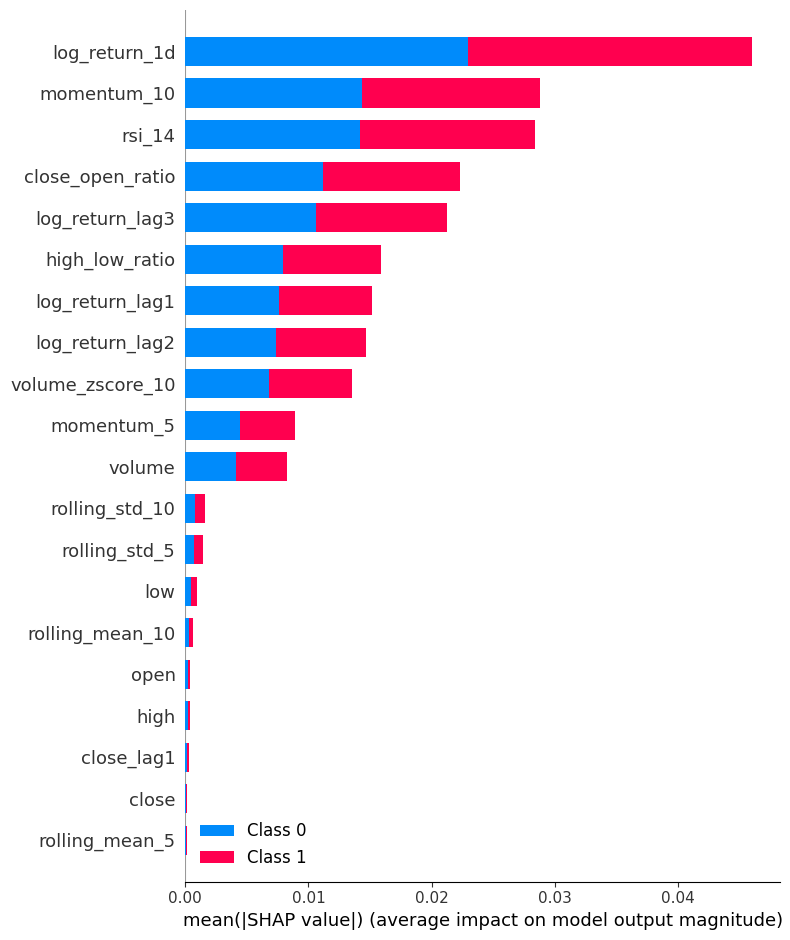

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


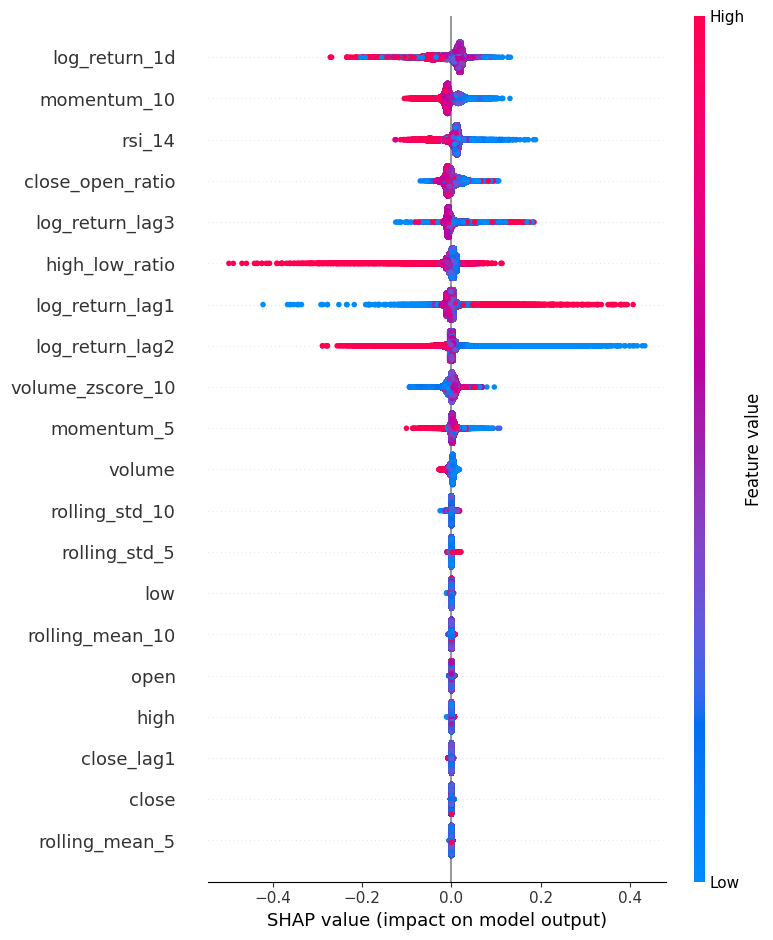

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Global Feature Importance Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


# Full SHAP Summary Plot
# shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values[1], X_test)


# Time series split for cross validation

In [15]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import optuna

X = df[['open', 'close', 'low', 'high', 'volume','close_lag1','log_return_lag1', 'log_return_lag2',
       'log_return_lag3', 'rolling_mean_5', 'rolling_mean_10', 'rolling_std_5',
       'rolling_std_10', 'momentum_5', 'momentum_10', 'volume_zscore_10', 'high_low_ratio', 'close_open_ratio']]
y = df["price_up_tomorrow"]

def objective(trial):
    # Define search space
    param_grid = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "metric": "binary_logloss",
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
    }

    tscv = TimeSeriesSplit(n_splits=5)
    scores = []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(
            param_grid,
            train_data,
            valid_sets=[val_data],
            num_boost_round=2000,
            callbacks=[
                        lgb.early_stopping(stopping_rounds=100),
                        lgb.log_evaluation(period=0)   # suppress logging
                        ]
        )

        preds = (model.predict(X_val) > 0.5).astype(int)
        scores.append(accuracy_score(y_val, preds))

    return np.mean(scores)


# Run the tuner
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best params:", study.best_params)
print("Best CV score:", study.best_value)




[I 2025-11-16 00:48:08,568] A new study created in memory with name: no-name-b7abf277-f5db-415d-8960-0f8c635f3fcd


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 00:49:49,419] Trial 0 finished with value: 0.5268359633340681 and parameters: {'learning_rate': 0.08159840912689101, 'num_leaves': 100, 'max_depth': 7, 'feature_fraction': 0.5346847983377476, 'bagging_fraction': 0.7517894550675359, 'bagging_freq': 1, 'min_data_in_leaf': 109}. Best is trial 0 with value: 0.5268359633340681.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 00:50:48,796] Trial 1 finished with value: 0.5255018809423913 and parameters: {'learning_rate': 0.12456285451575569, 'num_leaves': 26, 'max_depth': 5, 'feature_fraction': 0.6137181706722089, 'bagging_fraction': 0.41623879410996806, 'bagging_freq': 9, 'min_data_in_leaf': 65}. Best is trial 0 with value: 0.5268359633340681.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 00:54:56,998] Trial 2 finished with value: 0.5276708315258746 and parameters: {'learning_rate': 0.021445452648935395, 'num_leaves': 196, 'max_depth': 9, 'feature_fraction': 0.4977661181118095, 'bagging_fraction': 0.5421281124148316, 'bagging_freq': 10, 'min_data_in_leaf': 24}. Best is trial 2 with value: 0.5276708315258746.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.691437
[LightGBM] [Info] Number of positive: 145407, number of negative: 135838
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data point

[I 2025-11-16 00:55:40,727] Trial 3 finished with value: 0.5255473933480774 and parameters: {'learning_rate': 0.1916304367405034, 'num_leaves': 104, 'max_depth': 0, 'feature_fraction': 0.7288908449791551, 'bagging_fraction': 0.823325328609626, 'bagging_freq': 4, 'min_data_in_leaf': 51}. Best is trial 2 with value: 0.5276708315258746.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.691482
[LightGBM] [Info] Number of positive: 145407, number of negative: 135838
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 281245, number of used features: 18
[LightGB

[I 2025-11-16 00:56:23,818] Trial 4 finished with value: 0.5252188506695301 and parameters: {'learning_rate': 0.16059466789416216, 'num_leaves': 81, 'max_depth': -1, 'feature_fraction': 0.7363370867235415, 'bagging_fraction': 0.5774788323516549, 'bagging_freq': 3, 'min_data_in_leaf': 151}. Best is trial 2 with value: 0.5276708315258746.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-11-16 01:00:22,002] Trial 5 finished with value: 0.5204699155887101 and parameters: {'learning_rate': 0.014679273599401643, 'num_leaves': 130, 'max_depth': 1, 'feature_fraction': 0.915836468365338, 'bagging_fraction': 0.5306322556083828, 'bagging_freq': 10, 'min_data_in_leaf': 15}. Best is trial 2 with value: 0.5276708315258746.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.691565
[LightGBM] [Info] Number of positive: 145407, number of negative: 135838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data poin

[I 2025-11-16 01:01:32,557] Trial 6 finished with value: 0.5260466075479481 and parameters: {'learning_rate': 0.07631621120326855, 'num_leaves': 171, 'max_depth': -1, 'feature_fraction': 0.5536093861449041, 'bagging_fraction': 0.6285201215540569, 'bagging_freq': 1, 'min_data_in_leaf': 173}. Best is trial 2 with value: 0.5276708315258746.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 01:02:37,546] Trial 7 finished with value: 0.5241308197210943 and parameters: {'learning_rate': 0.08632519345748814, 'num_leaves': 207, 'max_depth': 10, 'feature_fraction': 0.5023746759503415, 'bagging_fraction': 0.4265541945887105, 'bagging_freq': 4, 'min_data_in_leaf': 29}. Best is trial 2 with value: 0.5276708315258746.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 01:04:29,756] Trial 8 finished with value: 0.527589762553246 and parameters: {'learning_rate': 0.10614449615746438, 'num_leaves': 93, 'max_depth': 4, 'feature_fraction': 0.7511413579577688, 'bagging_fraction': 0.7544519038058909, 'bagging_freq': 4, 'min_data_in_leaf': 116}. Best is trial 2 with value: 0.5276708315258746.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 01:05:36,310] Trial 9 finished with value: 0.5272626421373763 and parameters: {'learning_rate': 0.12794245186416922, 'num_leaves': 151, 'max_depth': 6, 'feature_fraction': 0.8131072299823594, 'bagging_fraction': 0.7656039571990374, 'bagging_freq': 1, 'min_data_in_leaf': 38}. Best is trial 2 with value: 0.5276708315258746.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 01:10:42,087] Trial 10 finished with value: 0.5284246307450523 and parameters: {'learning_rate': 0.0194081378452865, 'num_leaves': 251, 'max_depth': 12, 'feature_fraction': 0.4260874680578036, 'bagging_fraction': 0.9367818734922433, 'bagging_freq': 7, 'min_data_in_leaf': 79}. Best is trial 10 with value: 0.5284246307450523.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 01:24:44,915] Trial 11 finished with value: 0.5275357165714936 and parameters: {'learning_rate': 0.008201198504379038, 'num_leaves': 251, 'max_depth': 12, 'feature_fraction': 0.4035484788999109, 'bagging_fraction': 0.9791012710627551, 'bagging_freq': 7, 'min_data_in_leaf': 81}. Best is trial 10 with value: 0.5284246307450523.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 01:27:46,584] Trial 12 finished with value: 0.5273778454142695 and parameters: {'learning_rate': 0.042657669837509404, 'num_leaves': 254, 'max_depth': 9, 'feature_fraction': 0.41494079174406817, 'bagging_fraction': 0.9938729351682014, 'bagging_freq': 7, 'min_data_in_leaf': 81}. Best is trial 10 with value: 0.5284246307450523.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.690675
[LightGBM] [Info] Number of positive: 145407, number of negative: 135838
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 281245, number of used features: 18
[LightG

[I 2025-11-16 01:29:39,628] Trial 13 finished with value: 0.5276068297053783 and parameters: {'learning_rate': 0.0477683896578916, 'num_leaves': 203, 'max_depth': 12, 'feature_fraction': 0.6266496002800036, 'bagging_fraction': 0.8681055100567795, 'bagging_freq': 8, 'min_data_in_leaf': 10}. Best is trial 10 with value: 0.5284246307450523.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 01:31:49,763] Trial 14 finished with value: 0.5268331188087128 and parameters: {'learning_rate': 0.04496545543952683, 'num_leaves': 214, 'max_depth': 9, 'feature_fraction': 0.4568802573628558, 'bagging_fraction': 0.6248043414899581, 'bagging_freq': 10, 'min_data_in_leaf': 129}. Best is trial 10 with value: 0.5284246307450523.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 01:35:51,255] Trial 15 finished with value: 0.5287119278059464 and parameters: {'learning_rate': 0.027633218837782424, 'num_leaves': 229, 'max_depth': 10, 'feature_fraction': 0.6215570881641935, 'bagging_fraction': 0.8970851405066456, 'bagging_freq': 6, 'min_data_in_leaf': 76}. Best is trial 15 with value: 0.5287119278059464.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 01:37:50,787] Trial 16 finished with value: 0.5278571479366524 and parameters: {'learning_rate': 0.05670821079641274, 'num_leaves': 235, 'max_depth': 11, 'feature_fraction': 0.6459076368662705, 'bagging_fraction': 0.8966760904584735, 'bagging_freq': 6, 'min_data_in_leaf': 81}. Best is trial 15 with value: 0.5287119278059464.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 01:45:03,966] Trial 17 finished with value: 0.5296691105880345 and parameters: {'learning_rate': 0.02807973346547306, 'num_leaves': 173, 'max_depth': 7, 'feature_fraction': 0.9881195054817612, 'bagging_fraction': 0.9227668900225469, 'bagging_freq': 6, 'min_data_in_leaf': 193}. Best is trial 17 with value: 0.5296691105880345.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 01:50:44,397] Trial 18 finished with value: 0.527227085570434 and parameters: {'learning_rate': 0.06025161912461222, 'num_leaves': 171, 'max_depth': 3, 'feature_fraction': 0.9489386041759957, 'bagging_fraction': 0.8471429950677883, 'bagging_freq': 5, 'min_data_in_leaf': 177}. Best is trial 17 with value: 0.5296691105880345.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 01:56:06,584] Trial 19 finished with value: 0.529346256960198 and parameters: {'learning_rate': 0.031918385814353266, 'num_leaves': 177, 'max_depth': 7, 'feature_fraction': 0.8578208976233502, 'bagging_fraction': 0.9106762488970094, 'bagging_freq': 6, 'min_data_in_leaf': 199}. Best is trial 17 with value: 0.5296691105880345.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

[I 2025-11-16 01:57:57,506] Trial 20 finished with value: 0.528588190952987 and parameters: {'learning_rate': 0.09832985873027392, 'num_leaves': 135, 'max_depth': 7, 'feature_fraction': 0.9925087344210448, 'bagging_fraction': 0.7982604613291518, 'bagging_freq': 5, 'min_data_in_leaf': 196}. Best is trial 17 with value: 0.5296691105880345.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 02:02:38,146] Trial 21 finished with value: 0.5296648438000015 and parameters: {'learning_rate': 0.031949279698807405, 'num_leaves': 172, 'max_depth': 7, 'feature_fraction': 0.8537303619013029, 'bagging_fraction': 0.9310688098772538, 'bagging_freq': 6, 'min_data_in_leaf': 195}. Best is trial 17 with value: 0.5296691105880345.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 02:08:09,356] Trial 22 finished with value: 0.529188385802974 and parameters: {'learning_rate': 0.03373763791083741, 'num_leaves': 176, 'max_depth': 7, 'feature_fraction': 0.8482344172225382, 'bagging_fraction': 0.9333546885761346, 'bagging_freq': 8, 'min_data_in_leaf': 200}. Best is trial 17 with value: 0.5296691105880345.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 02:11:11,812] Trial 23 finished with value: 0.5282738709012167 and parameters: {'learning_rate': 0.06560425347757416, 'num_leaves': 182, 'max_depth': 6, 'feature_fraction': 0.8881635968987384, 'bagging_fraction': 0.9434378816973861, 'bagging_freq': 6, 'min_data_in_leaf': 172}. Best is trial 17 with value: 0.5296691105880345.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 02:14:56,697] Trial 24 finished with value: 0.5298056478050931 and parameters: {'learning_rate': 0.035605546726044386, 'num_leaves': 149, 'max_depth': 8, 'feature_fraction': 0.8044029280672071, 'bagging_fraction': 0.886646921779643, 'bagging_freq': 3, 'min_data_in_leaf': 153}. Best is trial 24 with value: 0.5298056478050931.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 02:27:04,947] Trial 25 finished with value: 0.5305196236692955 and parameters: {'learning_rate': 0.00696976350566398, 'num_leaves': 154, 'max_depth': 8, 'feature_fraction': 0.7945659840464921, 'bagging_fraction': 0.6926886256460378, 'bagging_freq': 3, 'min_data_in_leaf': 152}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 02:36:09,033] Trial 26 finished with value: 0.5301384572716735 and parameters: {'learning_rate': 0.011738300285318078, 'num_leaves': 151, 'max_depth': 8, 'feature_fraction': 0.7964551465329445, 'bagging_fraction': 0.6971524249346566, 'bagging_freq': 2, 'min_data_in_leaf': 150}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 03:12:29,741] Trial 27 finished with value: 0.5302920616408644 and parameters: {'learning_rate': 0.005915034827838923, 'num_leaves': 120, 'max_depth': 9, 'feature_fraction': 0.7897736667191605, 'bagging_fraction': 0.6847970165745789, 'bagging_freq': 2, 'min_data_in_leaf': 144}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 03:21:40,002] Trial 28 finished with value: 0.5292751438263132 and parameters: {'learning_rate': 0.005962080305472708, 'num_leaves': 64, 'max_depth': 10, 'feature_fraction': 0.6849392721293257, 'bagging_fraction': 0.7095069474552392, 'bagging_freq': 2, 'min_data_in_leaf': 139}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 11:01:03,055] Trial 29 finished with value: 0.5302579273365998 and parameters: {'learning_rate': 0.005718651292683702, 'num_leaves': 121, 'max_depth': 8, 'feature_fraction': 0.8059521185752796, 'bagging_fraction': 0.6752923353492757, 'bagging_freq': 2, 'min_data_in_leaf': 108}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 11:02:44,914] Trial 30 finished with value: 0.5267790728269605 and parameters: {'learning_rate': 0.14891195911855878, 'num_leaves': 120, 'max_depth': 5, 'feature_fraction': 0.7694648076704843, 'bagging_fraction': 0.6923872783541962, 'bagging_freq': 2, 'min_data_in_leaf': 102}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 11:19:47,342] Trial 31 finished with value: 0.5300787222392104 and parameters: {'learning_rate': 0.005423921882278308, 'num_leaves': 111, 'max_depth': 8, 'feature_fraction': 0.7965632923841869, 'bagging_fraction': 0.6855174828446102, 'bagging_freq': 2, 'min_data_in_leaf': 114}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 11:27:24,450] Trial 32 finished with value: 0.5295496405231083 and parameters: {'learning_rate': 0.01618545338783696, 'num_leaves': 153, 'max_depth': 8, 'feature_fraction': 0.6766543889302251, 'bagging_fraction': 0.6453863375073602, 'bagging_freq': 3, 'min_data_in_leaf': 153}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 11:34:46,003] Trial 33 finished with value: 0.5295851970900506 and parameters: {'learning_rate': 0.01627107660997345, 'num_leaves': 63, 'max_depth': 9, 'feature_fraction': 0.7736121422893628, 'bagging_fraction': 0.7197644864805596, 'bagging_freq': 1, 'min_data_in_leaf': 131}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 11:49:55,784] Trial 34 finished with value: 0.529922273344664 and parameters: {'learning_rate': 0.005111029338497787, 'num_leaves': 123, 'max_depth': 8, 'feature_fraction': 0.8356702259932068, 'bagging_fraction': 0.6644140224560123, 'bagging_freq': 2, 'min_data_in_leaf': 142}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 11:51:09,511] Trial 35 finished with value: 0.5264519524110908 and parameters: {'learning_rate': 0.1991512105911363, 'num_leaves': 93, 'max_depth': 4, 'feature_fraction': 0.7165322836847086, 'bagging_fraction': 0.5858201688252865, 'bagging_freq': 3, 'min_data_in_leaf': 98}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[435]	valid_0's binary_logloss: 0.690684
[LightGBM] [Info] Number of positive: 145407, number of negative: 135838
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 281245, number of used features: 18
[Light

[I 2025-11-16 11:57:53,713] Trial 36 finished with value: 0.5294145255687274 and parameters: {'learning_rate': 0.020747995831702316, 'num_leaves': 18, 'max_depth': 11, 'feature_fraction': 0.8801713254327587, 'bagging_fraction': 0.5983670703628896, 'bagging_freq': 2, 'min_data_in_leaf': 161}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 12:00:55,195] Trial 37 finished with value: 0.5277917238534785 and parameters: {'learning_rate': 0.0527802002048376, 'num_leaves': 146, 'max_depth': 6, 'feature_fraction': 0.9158592055709911, 'bagging_fraction': 0.5206127877652369, 'bagging_freq': 1, 'min_data_in_leaf': 121}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 12:02:58,827] Trial 38 finished with value: 0.5283776960766884 and parameters: {'learning_rate': 0.07371018243484498, 'num_leaves': 74, 'max_depth': 9, 'feature_fraction': 0.7439812631744612, 'bagging_fraction': 0.7955611308473087, 'bagging_freq': 4, 'min_data_in_leaf': 141}. Best is trial 25 with value: 0.5305196236692955.


[LightGBM] [Info] Number of positive: 72708, number of negative: 67916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 140624, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517038 -> initscore=0.068180
[LightGBM] [Info] Start training from score 0.068180
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-11-16 12:03:55,657] Trial 39 finished with value: 0.5252501404484394 and parameters: {'learning_rate': 0.18170778927848147, 'num_leaves': 106, 'max_depth': 11, 'feature_fraction': 0.7729052406875325, 'bagging_fraction': 0.7323402351119099, 'bagging_freq': 3, 'min_data_in_leaf': 164}. Best is trial 25 with value: 0.5305196236692955.


Best params: {'learning_rate': 0.00696976350566398, 'num_leaves': 154, 'max_depth': 8, 'feature_fraction': 0.7945659840464921, 'bagging_fraction': 0.6926886256460378, 'bagging_freq': 3, 'min_data_in_leaf': 152}
Best CV score: 0.5305196236692955


In [16]:
print("Best params:", study.best_params)
print("Best CV score:", study.best_value)

Best params: {'learning_rate': 0.00696976350566398, 'num_leaves': 154, 'max_depth': 8, 'feature_fraction': 0.7945659840464921, 'bagging_fraction': 0.6926886256460378, 'bagging_freq': 3, 'min_data_in_leaf': 152}
Best CV score: 0.5305196236692955


# Retrain Final model with Best Parameters

In [21]:
best_params = study.best_params  # or search.best_params_
best_params["objective"] = "binary"

final_data = lgb.Dataset(X, label=y)

final_model = lgb.train(
    best_params,
    final_data,
    num_boost_round=3000,
    valid_sets=[final_data],
    callbacks=[
        lgb.log_evaluation(100),
    ]
)




[LightGBM] [Info] Number of positive: 435754, number of negative: 407975
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 843729, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516462 -> initscore=0.065872
[LightGBM] [Info] Start training from score 0.065872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga